<h2>Table of Contents</h2>
<b>This lab takes a long time to run so the results are given. You can run the notebook your self but it may take a long time.</b>
<p>In this lab, we will compare a Convolutional Neural Network using Batch Normalization with a regular Convolutional Neural Network  to classify handwritten digits from the MNIST database. We will reshape the images to make them faster to process. </p>

<ul>
    <li><a href="#read_me">Read me Batch Norm for Convolution Operation  </a></li>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Two Types of Convolutional Neural Network</a></li>
<li><a href="#Train">Define Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>


<h2 id="read_me">Read me Batch Norm for Convolution Operation  </h2>

Like a fully connected network, we create a <code>BatchNorm2d</code> object, but we apply it to the 2D convolution object. First, we create objects <code>Conv2d</code> object; we require the number of output channels, specified by the variable <code>OUT</code>.  

<code>self.cnn1 = nn.Conv2d(in_channels=1, out_channels=OUT, kernel_size=5, padding=2) </code>

We then create a Batch Norm  object for 2D convolution as follows:

<code>self.conv1_bn = nn.BatchNorm2d(OUT)</code>

The parameter out is the number of channels in the output. We can then apply batch norm  after  the convolution operation :

<code>x = self.cnn1(x)</code>

<p></p>
 <code> x=self.conv1_bn(x)</code>


In [8]:

# Import the libraries we need to use in this lab

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

## Get Some Data

In [2]:

IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])


train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Make the validating 

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [5]:
# Show the data type for each element in dataset

train_dataset[0][0].shape

torch.Size([1, 16, 16])

In [6]:
# The label for the fourth data element

train_dataset[3][1]

1

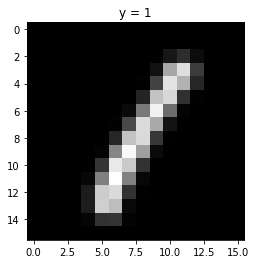

In [9]:
# The image for the fourth data element
show_data(train_dataset[3])


## Build a Two CNN class

In [18]:
class CNN (nn.Module):
  #Contructor
  def __init__(self,out_1=16,out_2=32):
      super(CNN,self).__init__()
      self.cnn1 =nn.Conv2d(in_channels=1,out_channels=out_1,kernel_size=5,padding=2)
      self.maxpool1=nn.MaxPool2d(kernel_size=2)

      self.cnn2 =nn.Conv2d(in_channels=out_1,out_channels=out_2,kernel_size=5,padding=2)
      self.maxpool2=nn.MaxPool2d(kernel_size=2)

      self.fc1=nn.Linear(out_2*4*4,10)

  
  #Prediction
  def forward(self,x):
    x=self.cnn1(x)
    x=torch.relu(x)
    x=self.maxpool1(x)
    x=self.cnn2(x)
    x=torch.relu(x)
    x=self.maxpool2(x)
    x=x.view(x.size(0),-1)
    x=self.fc1(x)
    return x

In [11]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [12]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):
    
    #global variable 
    N_test=len(validation_dataset)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

In [20]:
# Create the model object using CNN class
model = CNN(out_1=16, out_2=32)

In [22]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [23]:
# Train the model
accuracy_list_normal, loss_list_normal=train_model(model=model,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

In [24]:
model_batch=CNN_batch(out_1=16, out_2=32)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)
accuracy_list_batch, loss_list_batch=train_model(model=model_batch,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

<h2 id="Result">Analyze Results</h2> 


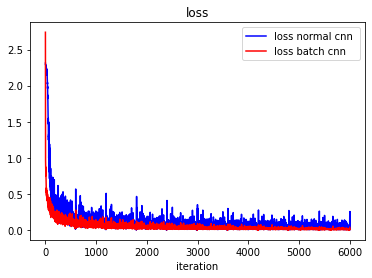

In [25]:
# Plot the loss and accuracy

plt.plot(loss_list_normal, 'b',label='loss normal cnn ')
plt.plot(loss_list_batch,'r',label='loss batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()

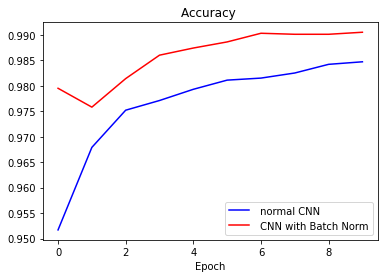

In [26]:
plt.plot(accuracy_list_normal, 'b',label=' normal CNN')
plt.plot(accuracy_list_batch,'r',label=' CNN with Batch Norm')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()